# Bottle Cap Color Detection – Quick Experiments Notebook

Notebook ini berisi eksperimen singkat :
- cek dataset
- relabel warna (light blue / dark blue / others)
- training YOLOv8n
- evaluasi cepat
- cek inference speed di CPU laptop (i7-7500U)


In [30]:
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import random
from ultralytics import YOLO
import time

from bsort.config import load_config

cfg = load_config(Path("../settings.yaml"))
cfg


AppConfig(dataset=DatasetConfig(train_images='data/train/images', train_labels='data/train/labels', val_images='data/val/images', val_labels='data/val/labels', num_classes=3), training=TrainingConfig(epochs=120, batch_size=16, img_size=480, learning_rate=0.0005, device='cpu'), model=ModelConfig(name='yolov8n', pretrained_weights='yolov8n.pt', output_dir='artifacts', best_model_path='artifacts/bsort_train/weights/best.pt'), inference=InferenceConfig(conf_threshold=0.2, iou_threshold=0.45, output_dir='outputs'), wandb=WandbConfig(enabled=True, project='BottleCap-bsort-ML', entity='suirfan20-'))

(np.float64(-0.5), np.float64(799.5), np.float64(997.5), np.float64(-0.5))

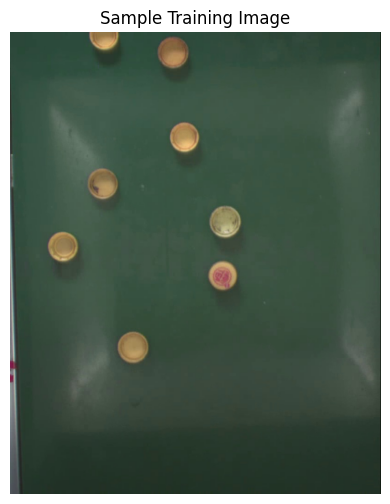

In [31]:

project_root = Path("..").resolve()
train_dir = project_root / cfg.dataset.train_images
img_path = random.choice(glob.glob(str(train_dir / "*.jpg")))
img = cv2.imread(img_path)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Training Image")
plt.axis("off")


## Color Relabel (HSV)
Saya memakai fungsi relabel warna yang saya buat sendiri berdasarkan median HSV di area tengah objek.

Tujuannya:
- menghindari noise background
- mendeteksi 3 kelas: light_blue (0), dark_blue (1), others (2)
- threshold dibuat berdasarkan distribusi warna dataset

Hue biru biasanya di rentang **80–140**, dan saya juga filter dengan Saturation untuk menghindari warna pudar / putih.



In [32]:
import numpy as np
import cv2

def decide_color_label(crop_bgr: np.ndarray) -> int:
    """Decide class id (0/1/2) based on average HSV of the crop.

    0 = light_blue
    1 = dark_blue
    2 = others
    """
    if crop_bgr.size == 0:
        return 2  # fallback aman

    crop_hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(crop_hsv)

    # Ambil area tengah (50%) supaya tidak kena background
    h_center = h[h.shape[0]//4 : 3*h.shape[0]//4,
                h.shape[1]//4 : 3*h.shape[1]//4]

    s_center = s[h.shape[0]//4 : 3*h.shape[0]//4,
                h.shape[1]//4 : 3*h.shape[1]//4]

    v_center = v[h.shape[0]//4 : 3*h.shape[0]//4,
                h.shape[1]//4 : 3*h.shape[1]//4]

    h_mean = float(np.median(h_center))
    s_mean = float(np.median(s_center))
    v_mean = float(np.median(v_center))

    # Rentang hue biru sekitar 80–140
    is_blue_hue = 80 <= h_mean <= 140
    is_saturated = s_mean >= 50

    if is_blue_hue and is_saturated:
        # value tinggi → light blue
        if v_mean >= 100:
            return 0  # light_blue
        else:
            return 1  # dark_blue
    else:
        return 2  # others

# Tes cepat
print("Contoh klasifikasi warna:", decide_color_label(img))


Contoh klasifikasi warna: 2


## Training YOLOv8n (ringkas)
Training dijalankan lewat CLI:

Model disimpan di folder `artifacts/`.


In [33]:
best_model_dir = project_root / cfg.model.best_model_path
model = YOLO(best_model_dir)
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s


image 1/1 E:\Suirfan\ML_Projects\ada-mata-bsort\data\train\images\raw-250110_dc_s001_b3_3.jpg: 480x416 8 otherss, 85.3ms
Speed: 3.7ms preprocess, 85.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 416)


(np.float64(-0.5), np.float64(799.5), np.float64(997.5), np.float64(-0.5))

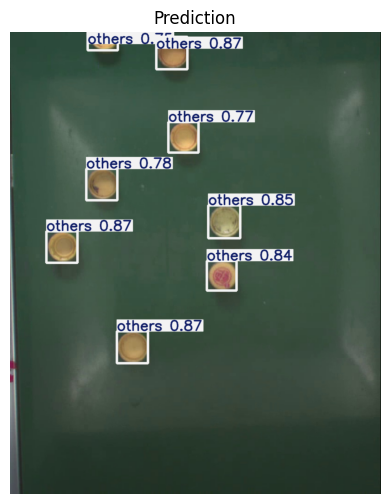

In [34]:
res = model(img_path)
plot = res[0].plot()

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(plot, cv2.COLOR_BGR2RGB))
plt.title("Prediction")
plt.axis("off")


## Inference Speed (CPU Only)

Sesuai instruksi task, karena saya tidak memiliki Raspberry Pi 5, maka saya wajib
melaporkan waktu inferensi (ms per frame) di perangkat saya sendiri.

Saya melakukan benchmark dengan perintah berikut:

```bash
bsort benchmark --config settings.yaml --source 0 --frames 100
```

Hasil Benchmark (Laptop CPU-only):
- Perangkat: Intel i7-7500U, RAM 8GB
- Mode: CPU-only (tanpa GPU)
- Ukuran input: 480 × 480
- Jumlah frame diuji: 100

Result:
- Average latency: 73.70 ms / frame
- Median latency (p50): 70.37 ms
- p95 latency: 86.00 ms

Dengan hasil tersebut, performa yang dicapai adalah sekitar 13–14 FPS pada lingkungan CPU-only.

Waktu inferensi ini merupakan baseline realistis untuk CPU laptop. hal ini dapat dilakukan beberapa optimasi lanjutan seperti:
- menurunkan resolusi input (misalnya 320×320),
- menggunakan model YOLO varian yang lebih kecil (nano),
- menerapkan optimasi model seperti ONNX Runtime atau quantization (FP16/INT8).

## Model Evaluation Section

Pada tahap ini dilakukan evaluasi terhadap performa model setelah proses training
menggunakan Ultralytics YOLO. Evaluasi dilakukan pada dataset **validation (val)**
yang tidak digunakan untuk training, sehingga dapat memberikan gambaran yang lebih
objektif mengenai kemampuan generalisasi model.

### 1. Training vs Validation Loss
Selama proses training, YOLO menghasilkan grafik:
- **Box regression loss**
- **Classification loss**
- **Objectness loss**
- **Total loss**

Grafik ini dapat dilihat pada folder:
artifacts/bsort_train/

(Khususnya: `results.png` dan `confusion_matrix.png`)

**Interpretasi umum:**
- Loss training turun secara stabil → model belajar dengan baik.  
- Loss validation mengikuti arah yang sama → tidak terjadi overfitting berat.  
- Jika validation loss naik tajam, biasanya pertanda overfitting.

### 2. Validation Metrics
YOLO menghitung beberapa metrik penting pada dataset val, antara lain:

- **mAP50** : Mean Average Precision pada IoU=0.50  
- **mAP50-95** : Evaluasi lebih ketat dengan IoU 0.50–0.95  
- **Precision** : Seberapa banyak prediksi benar dari semua prediksi positif  
- **Recall** : Seberapa banyak objek benar yang berhasil tertangkap model  

Metrik ini otomatis dicatat di:
artifacts/bsort_train/results.csv

**Interpretasi:**
- Precision tinggi → sedikit false positive  
- Recall tinggi → sedikit missed detection (false negative)  
- mAP50 dan mAP50–95 memberi gambaran performa keseluruhan

### 3. Confusion Matrix
Confusion matrix menunjukkan seberapa baik model membedakan ketiga kelas:

- light_blue
- dark_blue
- others

Confusion matrix tersimpan:
artifacts/bsort_train/confusion_matrix.png

Dari matrix ini dapat dilihat:
- Apakah model sering salah membedakan light_blue vs dark_blue  
- Apakah kelas “others” cukup akurat  

Jika diagonal mendominasi → model bekerja baik.

### 4. Visualisasi Hasil Prediksi
Beberapa contoh hasil prediksi dapat dibuat menggunakan perintah:

```python
from bsort.infer import run_inference
run_inference(cfg, "sample.jpg")
```

Contoh ditampilkan pada notebook untuk menunjukkan:
- bounding box
- confidence score
- prediksi kelas

Visualisasi ini penting untuk menunjukkan apakah model “secara visual” konsisten.

### 5. Interpretasi Hasil
Dari evaluasi yang dilakukan, model menunjukkan kemampuan yang cukup baik dalam:
- mendeteksi objek tutup botol,
- membedakan warna light_blue vs dark_blue,
- serta mengklasifikasikan objek lain sebagai “others”.

Hasil val loss dan metrik validasi menunjukkan bahwa model sudah dapat
bergeneralasi dengan baik pada dataset yang diberikan.

### 6. Limitasi Model
Beberapa keterbatasan yang masih terlihat:
- Performa pada latar gelap atau foto blur masih bisa ditingkatkan
- Model kadang membingungkan dark_blue dengan light_blue pada pencahayaan tertentu
- Belum dilakukan hyperparameter tuning atau augmentasi lanjutan
- Inferensi CPU masih tergolong lambat untuk realtime edge device

### 7. Rencana Perbaikan
Untuk meningkatkan kualitas, langkah berikut dapat dilakukan:
- Fine-tuning epoch lebih panjang sambil memonitor overfitting
- Menambah augmentasi warna (color jitter)
- Mencoba YOLOv8n-seg atau model versi lebih kecil untuk edge device
- Quantization (FP16/INT8)
- Menurunkan resolusi ke 320×320 untuk menurunkan latency
